# German Credit Classification

In [1]:
library(glmnet) # logistic regression
library(MASS)   # stepAIC
library(BBmisc) ## Normalization
library(fastDummies) ## 
library(stringr)
library(caret)
library(pscl)  # for Mcfaden statistic
library(e1071)
library (ROCR)

Warning message:
"package 'glmnet' was built under R version 4.1.3"
Loading required package: Matrix

Loaded glmnet 4.1-4

Warning message:
"package 'MASS' was built under R version 4.1.3"
Warning message:
"package 'BBmisc' was built under R version 4.1.3"

Attaching package: 'BBmisc'


The following object is masked from 'package:base':

    isFALSE


Warning message:
"package 'fastDummies' was built under R version 4.1.3"
Warning message:
"package 'caret' was built under R version 4.1.3"
Loading required package: ggplot2

Loading required package: lattice

Warning message:
"package 'pscl' was built under R version 4.1.3"
Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis



In [22]:
creditqualityimp_df <- read.csv("../datasets/German_Credit.csv",stringsAsFactors = TRUE)
dim(creditqualityimp_df)
str(creditqualityimp_df)
summary(creditqualityimp_df)
creditqualityimp_df <- creditqualityimp_df[,-1]
str(creditqualityimp_df)


[1] 1000   28

'data.frame':	1000 obs. of  28 variables:
 $ X                                 : int  1 2 3 4 5 6 7 8 9 10 ...
 $ months_loan_duration              : num  0.0294 0.6471 0.1176 0.5588 0.2941 ...
 $ amount                            : num  0.0506 0.3137 0.1016 0.4199 0.2542 ...
 $ installment_rate                  : num  1 0.333 0.333 0.333 0.667 ...
 $ age                               : num  0.8571 0.0536 0.5357 0.4643 0.6071 ...
 $ default                           : int  0 1 0 0 1 0 0 0 0 1 ...
 $ checking_balance_.0DM             : int  1 0 0 1 1 0 0 0 0 0 ...
 $ checking_balance__200DM           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ checking_balance_1.200DM          : int  0 1 0 0 0 0 0 1 0 1 ...
 $ credit_history_critical           : int  1 0 1 0 0 0 0 0 0 1 ...
 $ credit_history_fullyrepaid        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ credit_history_fullyrepaidthisbank: int  0 0 0 0 0 0 0 0 0 0 ...
 $ purpose_business                  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ purpose_car.new.   

       X          months_loan_duration     amount        installment_rate
 Min.   :   1.0   Min.   :0.0000       Min.   :0.00000   Min.   :0.0000  
 1st Qu.: 250.8   1st Qu.:0.1176       1st Qu.:0.06138   1st Qu.:0.3333  
 Median : 500.5   Median :0.2059       Median :0.11387   Median :0.6667  
 Mean   : 500.5   Mean   :0.2486       Mean   :0.16624   Mean   :0.6577  
 3rd Qu.: 750.2   3rd Qu.:0.2941       3rd Qu.:0.20481   3rd Qu.:1.0000  
 Max.   :1000.0   Max.   :1.0000       Max.   :1.00000   Max.   :1.0000  
      age            default    checking_balance_.0DM checking_balance__200DM
 Min.   :0.0000   Min.   :0.0   Min.   :0.000         Min.   :0.000          
 1st Qu.:0.1429   1st Qu.:0.0   1st Qu.:0.000         1st Qu.:0.000          
 Median :0.2500   Median :0.0   Median :0.000         Median :0.000          
 Mean   :0.2955   Mean   :0.3   Mean   :0.274         Mean   :0.063          
 3rd Qu.:0.4107   3rd Qu.:1.0   3rd Qu.:1.000         3rd Qu.:0.000          
 Max.   :1.000

'data.frame':	1000 obs. of  27 variables:
 $ months_loan_duration              : num  0.0294 0.6471 0.1176 0.5588 0.2941 ...
 $ amount                            : num  0.0506 0.3137 0.1016 0.4199 0.2542 ...
 $ installment_rate                  : num  1 0.333 0.333 0.333 0.667 ...
 $ age                               : num  0.8571 0.0536 0.5357 0.4643 0.6071 ...
 $ default                           : int  0 1 0 0 1 0 0 0 0 1 ...
 $ checking_balance_.0DM             : int  1 0 0 1 1 0 0 0 0 0 ...
 $ checking_balance__200DM           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ checking_balance_1.200DM          : int  0 1 0 0 0 0 0 1 0 1 ...
 $ credit_history_critical           : int  1 0 1 0 0 0 0 0 0 1 ...
 $ credit_history_fullyrepaid        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ credit_history_fullyrepaidthisbank: int  0 0 0 0 0 0 0 0 0 0 ...
 $ purpose_business                  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ purpose_car.new.                  : int  0 0 0 0 1 0 0 0 0 1 ...
 $ purpose_education   

In [8]:
## Y variable should have values 0 and 1 
head(creditqualityimp_df$default)
# Caret Library needs Y variable to be a factor
creditqualityimp_df$default <- as.factor(creditqualityimp_df$default)

[1] 0 1 0 0 1 0

In [9]:
## Create Data Partition
Train <- createDataPartition(creditqualityimp_df$default, p=0.8, list=FALSE)
training <- creditqualityimp_df[ Train, ]
testing <- creditqualityimp_df[ -Train, ]



In [10]:
fitControl <- trainControl(## 10-fold CV
     method = "cv",
     number = 10)

In [11]:
# Caret CQ model
caret_CQ_model <- train(default ~ . ,data=training,method="glm", family="binomial", trControl = fitControl)
summary(caret_CQ_model)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0975  -0.7136  -0.3770   0.7374   2.6788  

Coefficients:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -3.7995     0.6044  -6.287 3.25e-10 ***
months_loan_duration                 1.3508     0.6561   2.059 0.039516 *  
amount                               2.3596     0.8118   2.907 0.003655 ** 
installment_rate                     0.9374     0.2792   3.358 0.000786 ***
age                                 -1.1153     0.5207  -2.142 0.032195 *  
checking_balance_.0DM                1.7636     0.2562   6.883 5.85e-12 ***
checking_balance__200DM              0.2586     0.4693   0.551 0.581587    
checking_balance_1.200DM             1.3104     0.2518   5.204 1.95e-07 ***
credit_history_critical             -0.7131     0.2337  -3.051 0.002282 ** 
credit_history_fullyrepaid           0.9464     0.4236   2.234 0.025453 *  
credit_history_fullyrep

In [12]:
### Predict the values for test data unexposed to the model
cq_test_pred.probs <- predict(caret_CQ_model,newdata=testing,type = "prob")
head(cq_test_pred.probs)

,0,1
,<dbl>,<dbl>
8,0.7259419,0.2740581
12,0.1998409,0.8001591
14,0.6440604,0.3559396
18,0.2255952,0.7744048
23,0.8680257,0.1319743
26,0.6520136,0.3479864


In [14]:
## We need to convert the probabilities
cq_test_pred.probs.default <- cq_test_pred.probs$`1`
cq_test.pred.default <- ifelse(cq_test_pred.probs.default > 0.5, 1,0)

In [15]:
# Display the Number of Defaulters (1) and Non-defaulters (0)
table(testing$default)
table(cq_test.pred.default)


  0   1 
140  60 

cq_test.pred.default
  0   1 
162  38 

In [16]:
## Get the confusion matrix - predicted vs Actual
table(testing$default,cq_test.pred.default)

   cq_test.pred.default
      0   1
  0 128  12
  1  34  26

In [17]:
#Accuracy calculations
cm = as.matrix(table(testing$default,cq_test.pred.default))
#Total number of elements
n = sum(cm)
n

[1] 200

In [18]:
#diagonal elements - correctly classified
diag = diag(cm)
#Accuracy
accuracy = sum(diag) / n
#Print accuracy
accuracy

[1] 0.77

In [23]:
pred <- ROCR::prediction(cq_test.pred.default, testing$default);

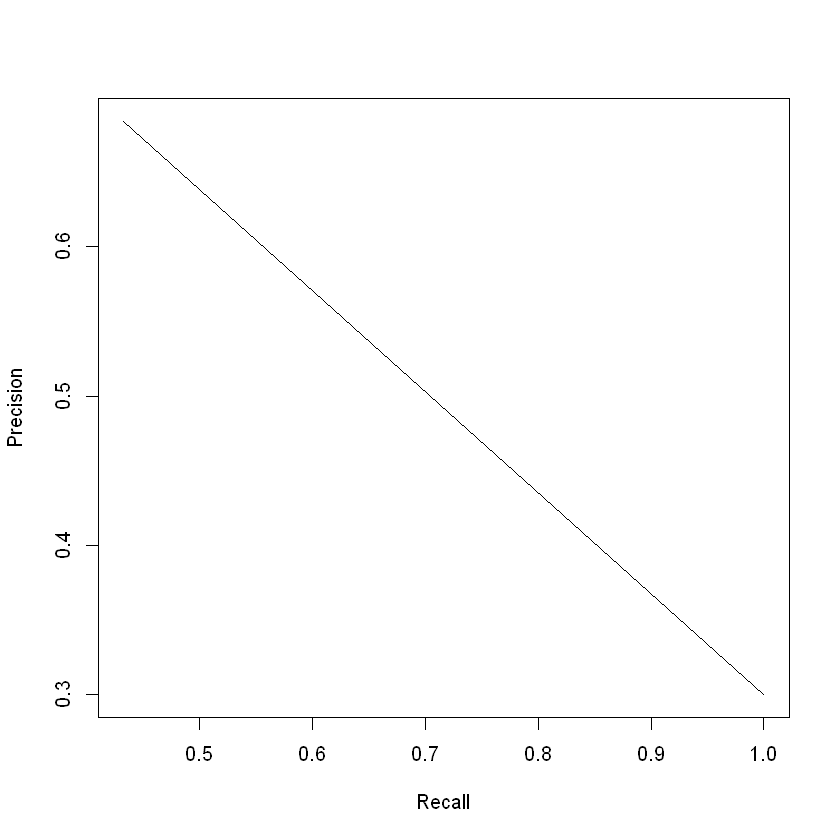

In [24]:
# Recall-Precision curve             
RP.perf <- ROCR::performance(pred, "prec", "rec");
plot (RP.perf);

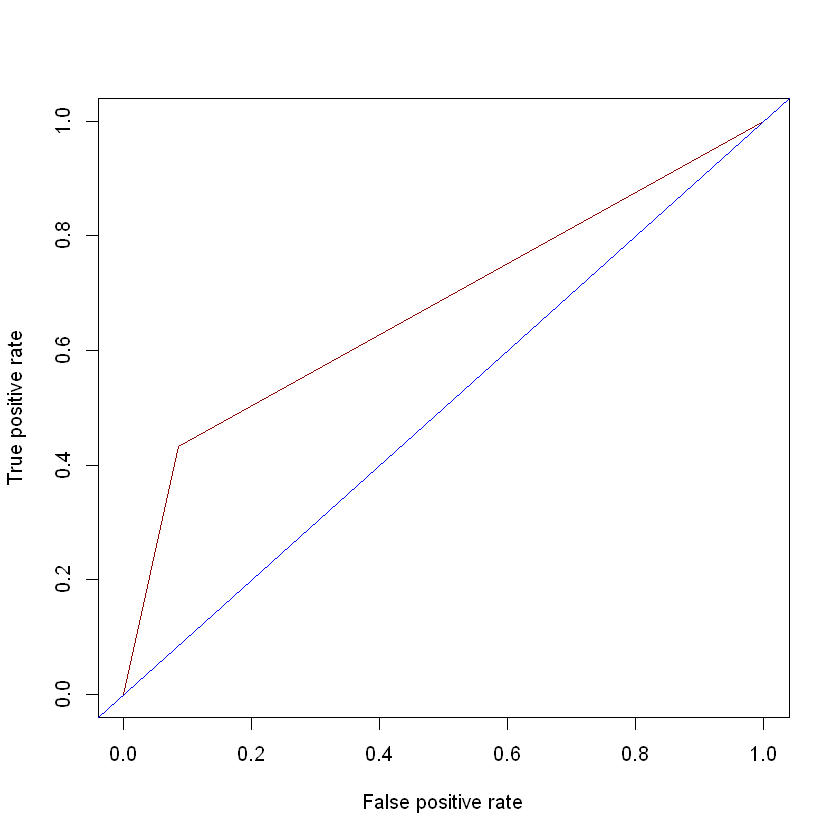

In [27]:
# ROC curve
ROC.perf <- ROCR::performance(pred, "tpr", "fpr");
plot (ROC.perf,col = "dark red");
abline(a=0.0,b=1,col = "blue")

In [28]:
# ROC area under the curve
auc.tmp <- ROCR::performance(pred,"auc");
auc <- as.numeric(auc.tmp@y.values)
auc
confusionMatrix(as.factor(cq_test.pred.default), testing$default,mode="everything")

[1] 0.6738095

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 128  34
         1  12  26
                                          
               Accuracy : 0.77            
                 95% CI : (0.7054, 0.8264)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.01687         
                                          
                  Kappa : 0.3883          
                                          
 Mcnemar's Test P-Value : 0.00196         
                                          
            Sensitivity : 0.9143          
            Specificity : 0.4333          
         Pos Pred Value : 0.7901          
         Neg Pred Value : 0.6842          
              Precision : 0.7901          
                 Recall : 0.9143          
                     F1 : 0.8477          
             Prevalence : 0.7000          
         Detection Rate : 0.6400          
   Detection Prevalence : 0.8100          
      Balanced Accuracy : 0.67